**Objective:** 

Compare dependence of first order and texture features on image artifact hadling method:
* Calculate features from original images.
* Remove slices before calculating first order and texture features.

In [1]:
import os
import nrrd

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from ioutil import sample_paths

%matplotlib inline

# T-test

https://pythonfordatascience.org/paired-samples-t-test-python/
https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

**FYI**:
* The t test (also called Student’s T Test) compares two averages (means) and tells you if they are different from each other.
* The t test also tells you how significant the differences are.
* In other words it lets you know if those differences could have happened by chance.

**t-score**:
* The t score is a ratio between the difference between two groups and the difference within the groups.
* The larger the t score, the more difference there is between groups. The smaller the t score, the more similarity there is between groups.
* A t score of 3 means that the groups are three times as different from each other as they are within each other. * When you run a t test, the bigger the t-value, the more likely it is that the results are repeatable.

**In conclusion**:
* A large t-score tells you that the groups are different.
* A small t-score tells you that the groups are similar.

**Rationale**
* The point is that 

In [71]:
first_order = {
    'original': pd.read_csv(
        './../../data_source/to_analysis/original_images/firstorder_original_images.csv',
        index_col=0
    ),
    'broken_images': pd.read_csv(
        './../../data_source/to_analysis/removed_broken_images/firstorder_removed_broken_images.csv',
        index_col=0
    ),
    'broken_images_slices': pd.read_csv(
        './../../data_source/to_analysis/removed_broken_images_and_slices/firstorder_removed_broken_images_and_slices.csv',
        index_col=0
    ),
}
texture = {
    'original': pd.read_csv(
        './../../data_source/to_analysis/original_images/texture_original_images.csv', 
        index_col=0
    ),
    'broken_images': pd.read_csv(
        './../../data_source/to_analysis/removed_broken_images/texture_removed_broken_images.csv', 
        index_col=0
    ),
    'broken_images_slices': pd.read_csv(
        './../../data_source/to_analysis/removed_broken_images_and_slices/texture_removed_broken_images_and_slices.csv', 
        index_col=0
    ),
}

In [72]:
for dset in first_order.values():
    print(dset.isnull().sum().any())
    
for dset in texture.values():
    print(dset.isnull().sum().any())

False
False
False
False
False
False


In [73]:
data = []
for key, dset in first_order.items():
    dset.columns = [f'{key}_{col}' for col in dset.columns]
    data.append(dset)
    
firstorder_data = pd.concat(data, axis=1)


data = []
for key, dset in texture.items():
    dset.columns = [f'{key}_{col}' for col in dset.columns]
    data.append(dset)
    
texture_data = pd.concat(data, axis=1)


firstorder_data.shape, texture_data.shape

((198, 132), (198, 1350))

In [74]:
texture_data.dropna().shape, firstorder_data.dropna().shape

((148, 1350), (148, 132))

In [75]:
texture_data.dropna(inplace=True)
firstorder_data.dropna(inplace=True)

In [76]:
texture_data.shape, firstorder_data.shape

((148, 1350), (148, 132))

In [77]:
firstorder_data.isnull().sum().any(), texture_data.isnull().sum().any()

(False, False)

# Feature Stability Test

In [ ]:
# NOTE:
# * feature values were generally robust when up to 50% of the GTV was removed, but having only a 
#   small fraction (less than 50%) of the GTV remaining in the ROI caused very large differences in feature values. 


# Intercorrelation Coefficient of all features

In [78]:
# https://github.com/cosanlab/nltools/blob/master/nltools/data/brain_data.py
# https://www.aliquote.org/cours/2012_biomed/biblio/Shrout1979.pdf
def icc(X):
    """Calculate intraclass correlation coefficient (ICC). 
    
    Reference: 
        Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
        assessing rater reliability. Psychological bulletin, 86(2), 420.
    
    Args:
        X (array-like): Data matrix with observations on rows
            and measurements on columns.

    Returns:
        (float): Intraclass correlation coefficient.
                
    """
    n, k = np.shape(X)

    # Degrees of Freedom.
    dfc = k - 1
    dfe = (n - 1) * (k - 1)
    dfr = n - 1

    # Sum Square Total.
    mean_X = np.mean(X)
    SST = ((X - mean_X) ** 2).sum()

    # Create the design matrix for the different levels:
    # * Sessions.
    d = np.kron(np.eye(k), np.ones((n, 1)))  
    # * Subjects.
    d0 = np.tile(np.eye(n), (k, 1))  
    D = np.hstack([d, d0])

    # Sum Square Error.
    predicted_X = np.dot(
        np.dot(
            np.dot(
                D, np.linalg.pinv(np.dot(D.T, D))), D.T
            ), 
            X.flatten('F')
        )
    residuals = X.flatten('F') - predicted_X
    SSE = np.sum(residuals ** 2)
    MSE = SSE / dfe

    # Sum square column effect (between colums).
    SSC = np.sum((np.mean(X, 0) - mean_X) ** 2) * n
    MSC = SSC / dfc / n

    # Sum Square subject effect (between rows/subjects).
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    ICC = (MSR - MSE) / (MSR + (k - 1) * MSE)
    
    return ICC

In [81]:
col_regexes = np.unique([('_').join(col.split('_')[-3:-1]) for col in texture_data.columns])

all_feat_icc = np.zeros(col_regexes.size)
for num, label in enumerate(col_regexes):
    all_feat_icc[num] = icc(texture_data.filter(regex=label).values)

In [85]:
df_icc_texture_data = pd.DataFrame(
    all_feat_icc,
    index=col_regexes,
    columns=['Score']
)

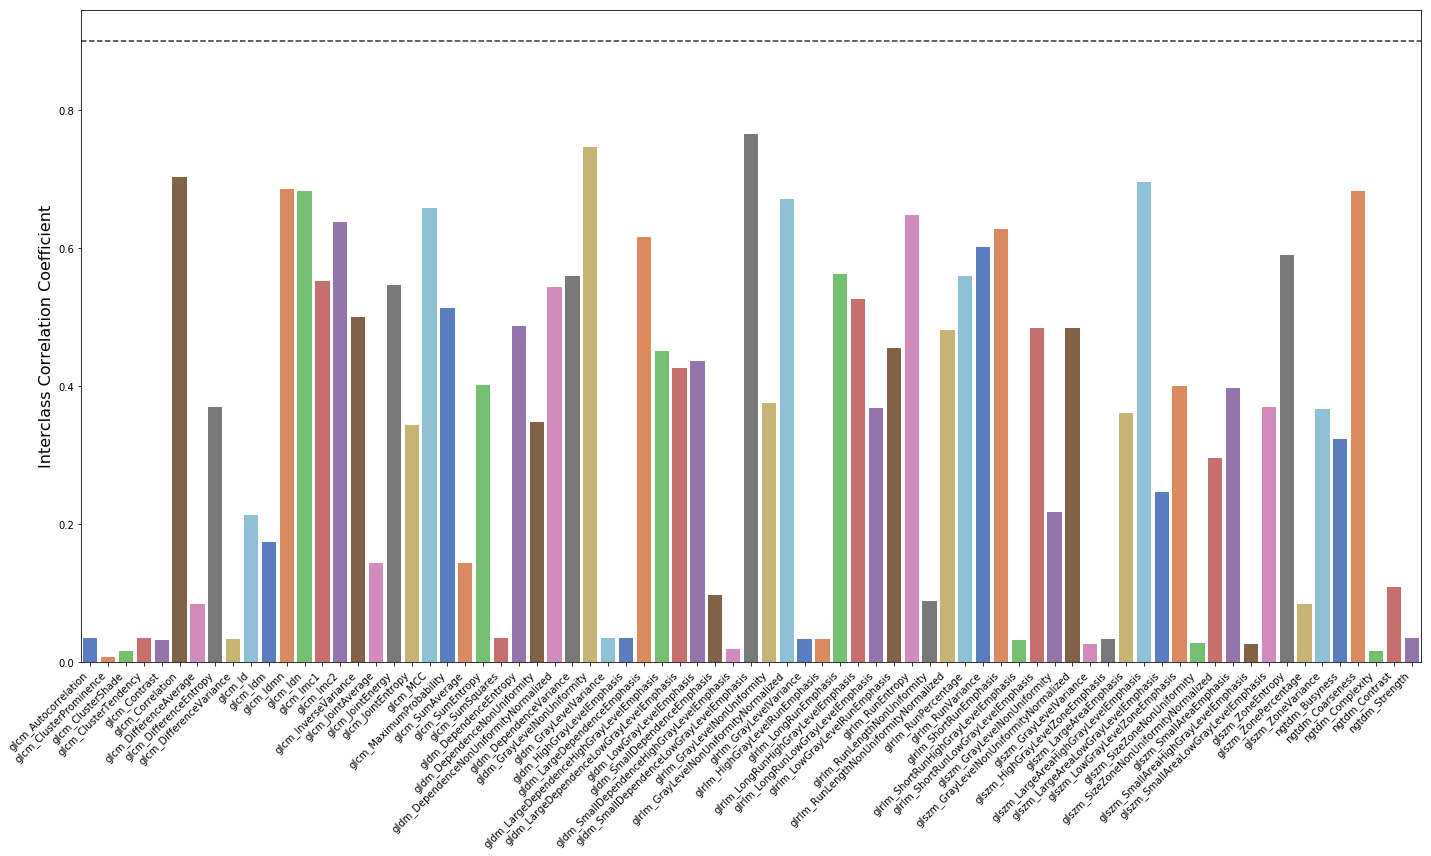

In [89]:
# Plotting features with ICC > 0.9.
plt.figure(figsize=(20, 12))
sns.barplot(
    x=df_icc_texture_data.index, 
    y='Score', 
    data=df_icc_texture_data, 
    #palette='PuBu',
    palette='muted',
)
plt.ylabel('Interclass Correlation Coefficient', fontsize=16)
plt.xticks(
    np.arange(df_icc_texture_data.index.size), df_icc_texture_data.index, rotation=45, ha='right'
)
plt.axhline(y=0.9, linestyle='--', alpha=0.8, color='k')#'darkblue')
plt.tight_layout()
#plt.savefig(
#    './icc_original_images.png'
#)

In [90]:
col_regexes = np.unique([('_').join(col.split('_')[-3:-1]) for col in firstorder_data.columns])

all_feat_icc = np.zeros(col_regexes.size)
for num, label in enumerate(col_regexes):
    all_feat_icc[num] = icc(firstorder_data.filter(regex=label).values)

In [91]:
df_icc_texture_data = pd.DataFrame(
    all_feat_icc,
    index=col_regexes,
    columns=['Score']
)

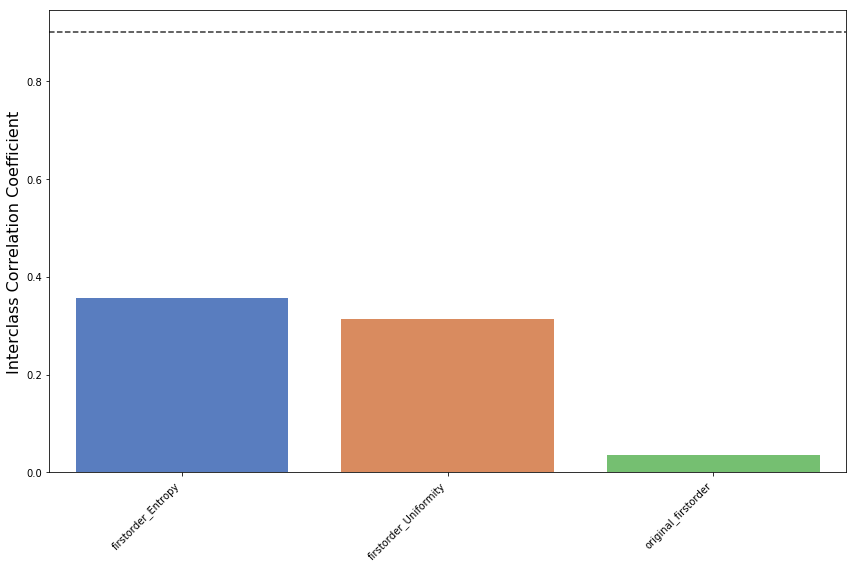

In [93]:
# Plotting features with ICC > 0.9.
plt.figure(figsize=(12, 8))
sns.barplot(
    x=df_icc_texture_data.index, 
    y='Score', 
    data=df_icc_texture_data, 
    #palette='PuBu',
    palette='muted',
)
plt.ylabel('Interclass Correlation Coefficient', fontsize=16)
plt.xticks(
    np.arange(df_icc_texture_data.index.size), df_icc_texture_data.index, rotation=45, ha='right'
)
plt.axhline(y=0.9, linestyle='--', alpha=0.8, color='k')#'darkblue')
plt.tight_layout()
#plt.savefig(
#    './icc_original_images.png'
#)

# Reduction in tumor volume

In [106]:
path_original_images = './../../data_source/images/masks_nrrd/'
path_reduced_images = './../../data_source/images/masks_removed_broken_images_and_slices/'

original_images = []
reduced_images = []  
for fname in os.listdir(path_reduced_images):
    
    path_to_file = os.path.join(path_reduced_images, fname)
    if path_to_file.endswith('.nrrd'):
        red_img, _ = nrrd.read(path_to_file)
        reduced_images.append(np.sum(red_img))
        
    path_to_file = os.path.join(path_original_images, fname)
    if path_to_file.endswith('.nrrd'):
        orig_img, _ = nrrd.read(path_to_file)
        original_images.append(np.sum(orig_img))
    
len(reduced_images), len(original_images)

(148, 148)

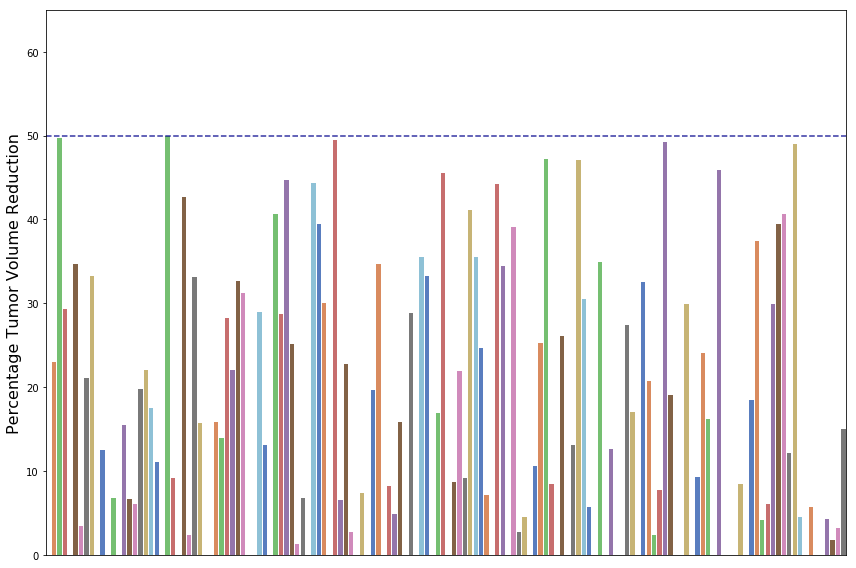

In [123]:
volume_reduction = 1 - np.array(reduced_images) / np.array(original_images)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=np.arange(np.size(volume_reduction)),
    y=volume_reduction * 100,
    palette='muted',
)
plt.ylabel('Percentage Tumor Volume Reduction', fontsize=16)
plt.xticks([], [], rotation=45, ha='right')
plt.axhline(y=50, linestyle='--', alpha=0.8, color='darkblue')
plt.ylim([0, 65])
plt.tight_layout()

3636844.5945945946


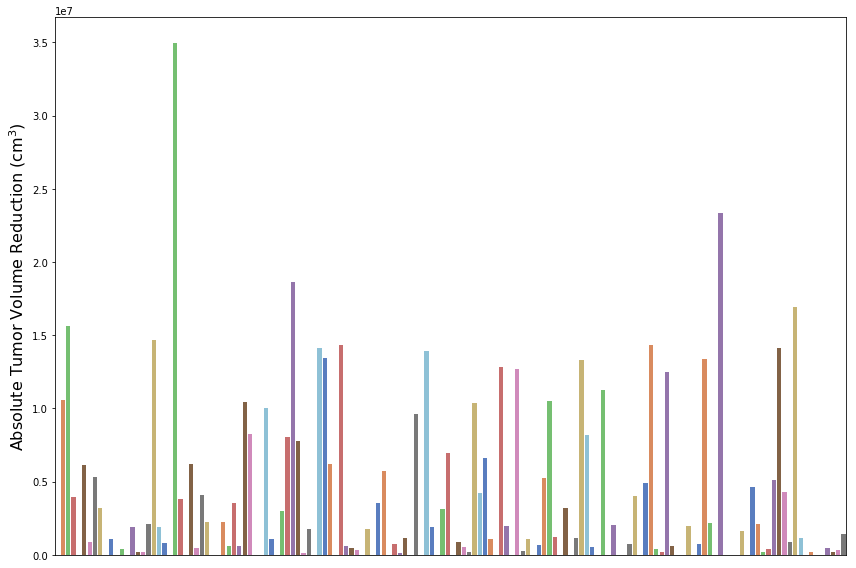

In [130]:
# NOTE: 
# * From article: On average, 3.0cm^3 of GTV had to be removed to eliminate streak artifacts 
#   (standard deviation: 4.0cm3, range: 0.11–28cm3)).

volume_reduction = (np.array(original_images) - np.array(reduced_images)) * 1000

average_volume_reduction = np.mean(volume_reduction)
print(average_volume_reduction)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=np.arange(np.size(volume_reduction)),
    y=volume_reduction,
    palette='muted',
)
plt.ylabel(r'Absolute Tumor Volume Reduction (cm$^3$)', fontsize=16)
plt.xticks([], [], rotation=45, ha='right')
#plt.axhline(y=50, linestyle='--', alpha=0.8, color='darkblue')
#plt.ylim([0, 65])
plt.tight_layout()